# Two‑Stage Deep Ensemble Paradigm Based on Optimal Multi‑scale Decomposition and Multi‑factor Analysis for Stock Price Prediction

### Setup

In [ ]:
%pip install pandas yfinance matplotlib pyts vmdpy tensorflow tti tqdm

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
from vmdpy import VMD
from tti.indicators import BollingerBands, WilliamsAccumulationDistribution, \
    ChaikinMoneyFlow, ChaikinOscillator, OnBalanceVolume, TimeSeriesForecast, \
    CommodityChannelIndex, MovingAverageConvergenceDivergence
import tensorflow as tf
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm

### Download Data from Yahoo Finance and Pickle it

In [2]:
start_date = datetime(2014, 10, 28)
end_date   = datetime(2022, 10, 28)

In [3]:
# stock_data = yf.download('399001.SZ', start=start_date, end=end_date)  # SZI
# stock_data = yf.download('SPY', start=start_date, end=end_date)  # SPY
stock_data = yf.download('000001.SS', start=start_date, end=end_date)  # SSEC

[*********************100%%**********************]  1 of 1 completed


In [4]:
pd.to_pickle(stock_data, 'ssec_data.pkl')

## Optimal Multi-scale Decomposition

In [30]:
# Read data from pickle files
stock_data = pd.read_pickle('ssec_data.pkl')
stock_data.columns = stock_data.columns.str.lower()
if len(stock_data) % 2 != 0:  # necessary for VMD
    stock_data = stock_data[1:]

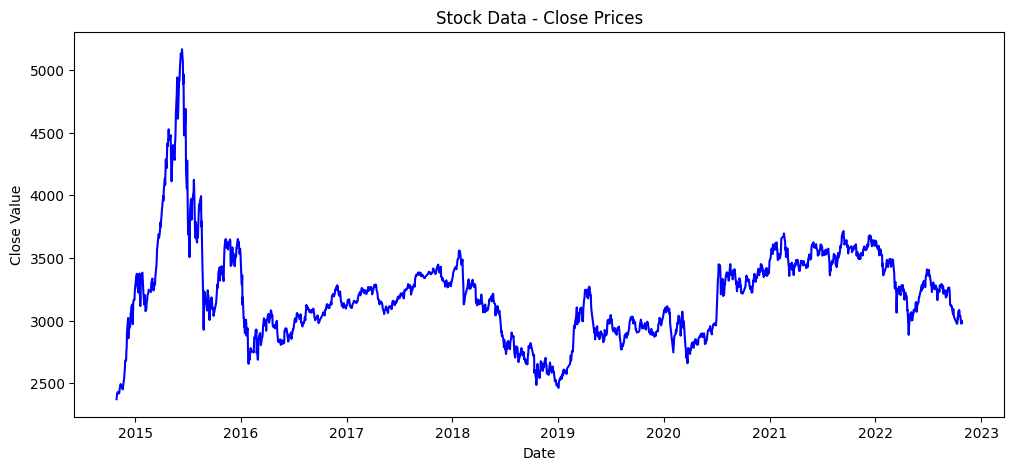

In [31]:
plt.figure(figsize=(12, 5))  # Set the figure size to be wider
plt.plot(stock_data.index, stock_data['close'], color='blue')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Stock Data - Close Prices')
plt.show()

### Singular Spectrum Analysis (SSA)

In [32]:
# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=10)
X_ssa = ssa.fit_transform(stock_data["close"].values.reshape(1, -1))

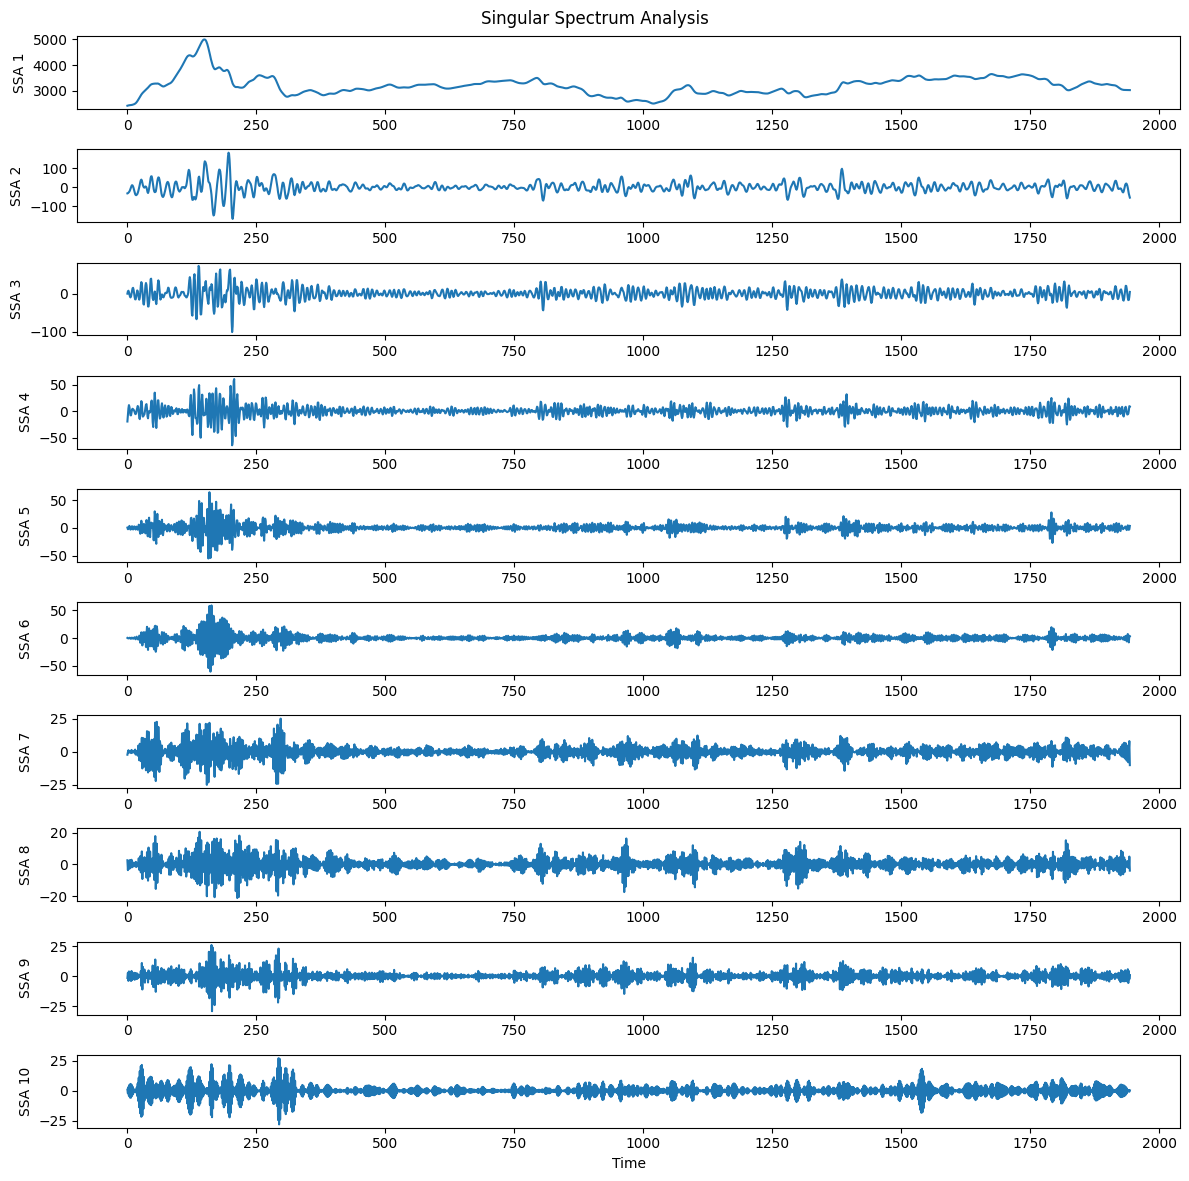

In [33]:
# Plot SSA
num_plots = X_ssa.shape[1]
fig, axs = plt.subplots(num_plots, 1, figsize=(12, 12))
fig.suptitle('Singular Spectrum Analysis')

# Plot each column of X_ssa on a separate subplot
for i in range(num_plots):
    axs[i].plot(X_ssa[0, i, :])
    axs[i].set_ylabel(f'SSA {i+1}')

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

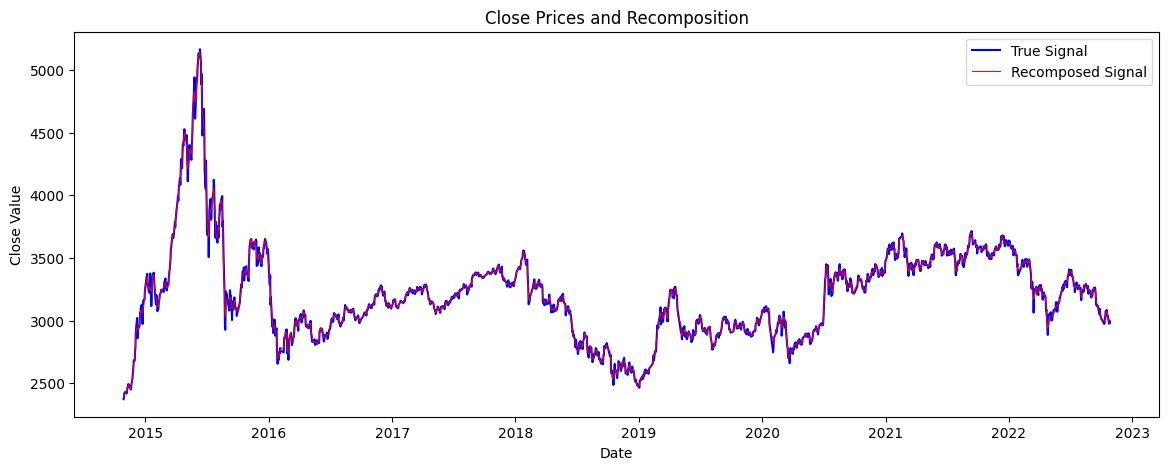

In [34]:
# Reconstruction of the original signal
first_three_decompositions = X_ssa[0, :3, :]
recomposition = np.sum(first_three_decompositions, axis=0)

# Plot reconstructed (denoised) signal
plt.figure(figsize=(14, 5))
plt.plot(stock_data.index, stock_data['close'], color='blue', label='True Signal')
plt.plot(stock_data.index, recomposition, color='red', label='Recomposed Signal', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close Prices and Recomposition')
plt.legend()
plt.show()

### VMD Decomposition

1942


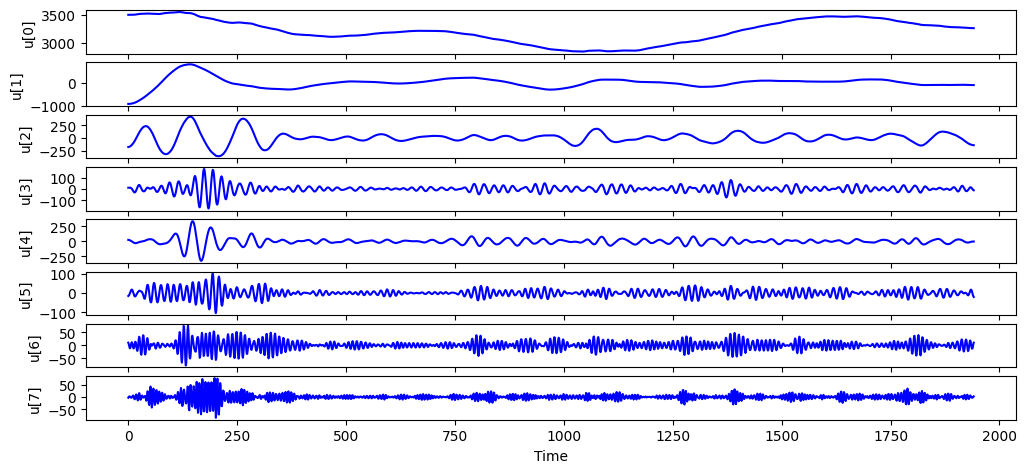

In [35]:
# Perform Example Variational Mode Decomposition
K = 8  # Number of modes
u, _, _ = VMD(stock_data["close"].values[2:], alpha=2000, tau=0, K=K, DC=0, init=2, tol=1e-6)

plt.figure(figsize=(12, 6))
for i in range(K):
    plt.subplot(K+1, 1, i+1)  # Create the subplot for u[i]
    plt.plot(u[i], color='blue')
    plt.xlabel('Time')
    plt.ylabel(f'u[{i}]')

plt.show()

In [36]:
# SAMPEN ALGORITHM
# Credit: https://en.wikipedia.org/wiki/Sample_entropy
from itertools import combinations
from math import log

def construct_templates(timeseries_data: list, m: int = 2):
    num_windows = len(timeseries_data) - m + 1
    return [timeseries_data[x : x + m] for x in range(0, num_windows)]


def get_matches(templates: list, r: float):
    return len(
        list(filter(lambda x: is_match(x[0], x[1], r), combinations(templates, 2)))
    )


def is_match(template_1: list, template_2: list, r: float):
    return all([abs(x - y) < r for (x, y) in zip(template_1, template_2)])


def sample_entropy(timeseries_data: list, window_size: int, r: float):
    B = get_matches(construct_templates(timeseries_data, window_size), r)
    A = get_matches(construct_templates(timeseries_data, window_size + 1), r)
    return -log(A / B)

In [38]:
# Use SampEn to determine the optimal number of nodes for VMD
max_K = 10
sampen_threshold = 0.001
sampen_filtering = 0.2*np.std(stock_close)
optimal_nodes = 0
imf_n = None
stock_close = stock_data['close']

for i in tqdm(range(2, max_K)):
    u, _, _ = VMD(stock_close.values, alpha=2000, tau=0, K=i, DC=0, init=2, tol=1e-6)

    # this just calculates the last two and takes the difference
    if abs(sample_entropy(u[-1], 2, sampen_filtering)-
           sample_entropy(u[-2], 2, sampen_filtering)) < sampen_threshold:
        optimal_nodes = i
        imf_n = u
        break

print(f'Optimal number of nodes for VMD: {optimal_nodes}')

 50%|█████     | 4/8 [01:23<01:23, 20.89s/it]

Optimal number of nodes for VMD: 6


### ApEn Reconstruction

In [39]:
# ApEn ALGORITHM (Credit: https://en.wikipedia.org/wiki/Approximate_entropy#Python_implementation)
def ApEn(U, m, r) -> float:
    """Approximate_entropy.
    :param U: list of data points
    :param m: length of compared run of data
    :param r: filtering level
    """

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [40]:
apen_threshold = 10
apen_vals = [ApEn(imf_n[i], 2, apen_threshold) for i in tqdm(range(len(imf_n)))]

greater_indices = [i for i in range(len(apen_vals)) if apen_vals[i] > np.mean(apen_vals)]
less_indices = [i for i in range(len(apen_vals)) if apen_vals[i] <= np.mean(apen_vals)]

print("Indices where apen_vals[i] is greater than the mean:", greater_indices)
print("Indices where apen_vals[i] is less than the mean:", less_indices)

100%|██████████| 6/6 [00:40<00:00,  6.77s/it]


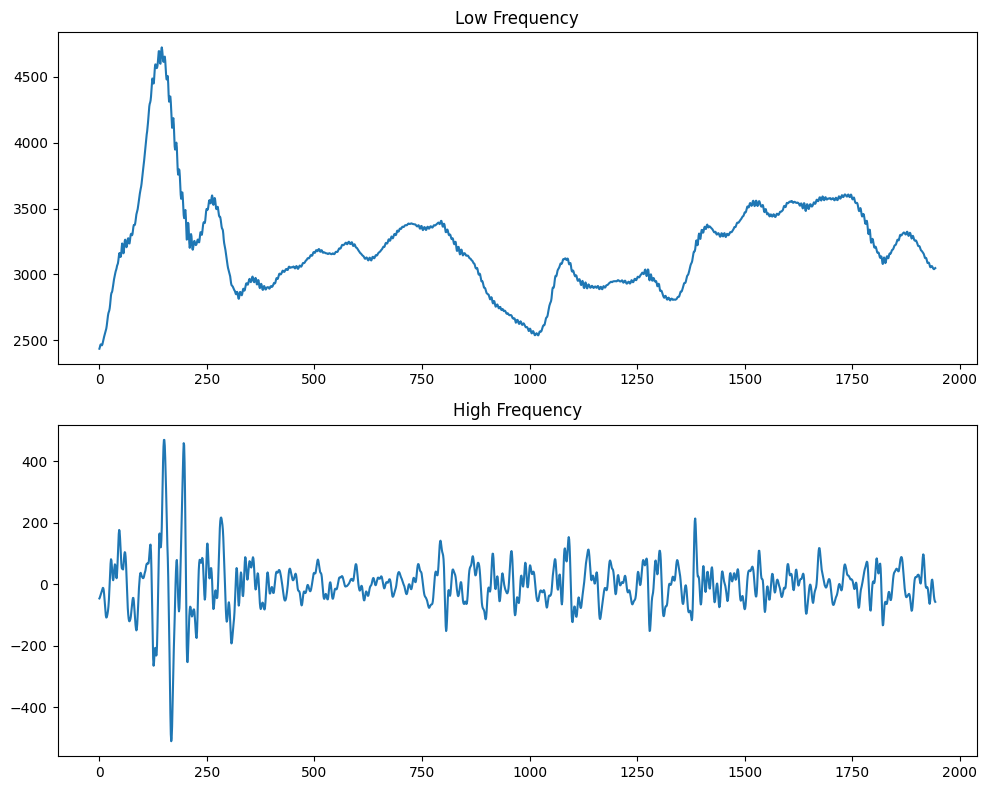

In [42]:
low_frequency = np.sum([imf_n[i] for i in less_indices], axis=0)
high_frequency = np.sum([imf_n[i] for i in greater_indices], axis=0)
stock_data['low frequency'] = low_frequency
stock_data['high frequency'] = high_frequency
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(low_frequency)
axs[0].set_title('Low Frequency')
axs[1].plot(high_frequency)
axs[1].set_title('High Frequency')
plt.tight_layout()
plt.show()

## Multivariate Analysis

### Spearman and MI Feature Tests

In [43]:
def spearman_mi_tests(data, target, plot_vars=True):
    '''
    Executes the spearman and MI tests on the variables in data with the target
    variable
    :param data: The variables associated with the stock price
    :param target: The target variable for the tests. Namely, high or low freq decomp.
    '''

    if not {'high', 'low', 'open', 'close'}.issubset([col.lower() for col in data.columns]):
        raise ValueError("Data must contain 'high', 'low', 'open', and 'close' columns.")
    

    boll_bands = BollingerBands(data)
    wvad = WilliamsAccumulationDistribution(data)
    cmf = ChaikinMoneyFlow(data)
    cosc = ChaikinOscillator(data)
    obv = OnBalanceVolume(data)
    tsf = TimeSeriesForecast(data)
    cci = CommodityChannelIndex(data)
    macd = MovingAverageConvergenceDivergence(data)

    bolls = boll_bands.getTiData()
    boll_high = bolls['upper_band']
    boll_low = bolls['lower_band']
    wvad_vals = wvad.getTiData()['wad']
    cmf_vals = cmf.getTiData()['cmf']
    cosc_vals = cosc.getTiData()['co']
    obv_vals = obv.getTiData()['obv']
    tsf_vals = tsf.getTiData()['tsf']
    cci_vals = cci.getTiData()['cci']
    macd_vals = macd.getTiData()['macd']

    stat_variables = {
        'open': data['open'], 
        'high': data['high'],
        'low': data['low'],
        'MA5': data['close'].rolling(window=5).mean(),
        'MA10': data['close'].rolling(window=10).mean(),
        'EMA20': data['close'].ewm(span=20, adjust=False).mean(),
        'BOLL_high': boll_high,
        'BOLL_low': boll_low,
        'WVAD': wvad_vals,
        'AD': cmf_vals,
        'ADOSC': cosc_vals,
        'OBV': obv_vals,
        'TSF': tsf_vals,
        'CCI': cci_vals,
        'MACD': macd_vals
    }

    spearman_mi_scores = {
        'open': [0,0], 'high': [0,0], 'low': [0,0], 'MA5': [0,0],'MA10': [0,0],'EMA20': [0,0],'BOLL_high': [0,0],
        'BOLL_low': [0,0],'WVAD': [0,0],'AD': [0,0],'ADOSC': [0,0],'OBV': [0,0],'TSF': [0,0],'CCI': [0,0],'MACD': [0,0],
    }

    for key, value in stat_variables.items():
        aligned_prices, aligned_value = target.align(value, join='inner', axis=0)
        non_nan_value = aligned_value.dropna()
        non_nan_prices = aligned_prices.loc[non_nan_value.index]
        
        # calc spearman scores
        spearman_mi_scores[key][0] = non_nan_prices.corr(non_nan_value, method='spearman')

        # convert to arrays to calc. mi score
        vals_array = non_nan_value.values.reshape(-1, 1)
        prices_array = non_nan_prices.values

        # calc mi scores
        spearman_mi_scores[key][1] = mutual_info_regression(vals_array, prices_array)[0]

    if plot_vars:
        # Extracting the variable names and MI scores
        variables = list(spearman_mi_scores.keys())
        spearman_scores = [x[0] for x in spearman_mi_scores.values()]

        # Plotting the bar graph
        plt.figure(figsize=(10, 6))
        plt.bar(variables, spearman_scores)
        plt.xlabel('Variables')
        plt.ylabel('Spearman Scores')
        plt.title('Spearman Scores')
        plt.xticks(rotation=45)
        plt.show()

        # Extracting the var names and spearman scores
        # variables = list(spearman_mi_scores.keys())
        mi_scores = [x[1] for x in spearman_mi_scores.values()]

        # Plotting the bar graph
        plt.figure(figsize=(10, 6))
        plt.bar(variables, mi_scores)
        plt.xlabel('Variables')
        plt.ylabel('MI Scores')
        plt.title('MI Scores')
        plt.xticks(rotation=45)
        plt.show()


    for key, value in spearman_mi_scores.items():
        mi_mean = np.mean(list(spearman_mi_scores.values()))
        if spearman_mi_scores[key][0] > 0.05 and spearman_mi_scores[key][1] > mi_mean:
            print(f'{key} is a good feature')
        else:
            stat_variables.pop(key, None)

    return pd.DataFrame(stat_variables)

### Principal Component Analysis

In [44]:
def scale_variables(features):
    '''
    Scales feauture input using StandardScaler to mean 0 and unit stdv and drop
    all rows which contain NaN in some features
    '''
    variable_scaler = StandardScaler()
    standard_features = pd.DataFrame(variable_scaler.fit_transform(features), 
        columns=features.columns, 
        index=features.index)

    return standard_features.dropna()

c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\utils\data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\utils\data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\indicators\_bollinger_bands.py:100: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  bb = self._input_data.rolling(
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\indicators\_bollinger_bands.py:105: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future ve

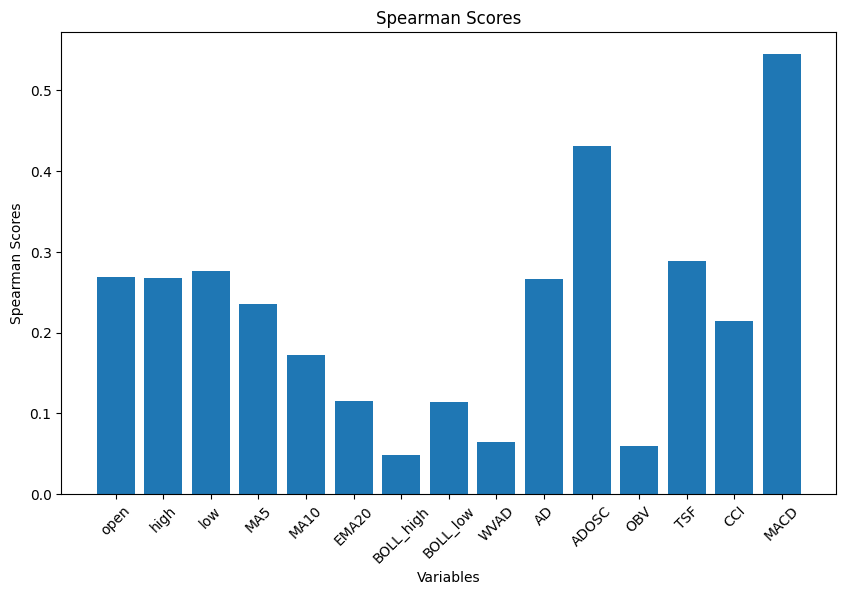

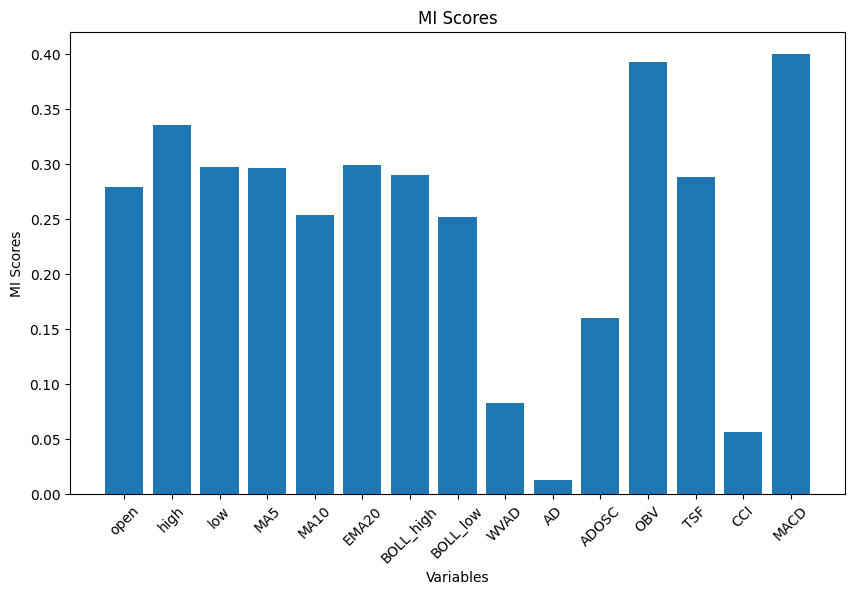

open is a good feature
high is a good feature
low is a good feature
MA5 is a good feature
MA10 is a good feature
EMA20 is a good feature
BOLL_low is a good feature
OBV is a good feature
TSF is a good feature
MACD is a good feature


c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\utils\data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\utils\data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\indicators\_bollinger_bands.py:100: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  bb = self._input_data.rolling(
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\indicators\_bollinger_bands.py:105: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future ve

open is a good feature
high is a good feature
low is a good feature
MA5 is a good feature
MA10 is a good feature
EMA20 is a good feature
BOLL_high is a good feature
BOLL_low is a good feature
OBV is a good feature
TSF is a good feature


c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\utils\data_preprocessing.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\utils\data_preprocessing.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\indicators\_moving_average_convergence_divergence.py:72: FutureWarning: The 'axis' keyword in DataFrame.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  ema_26 = self._input_data.ewm(span=26, min_periods=26, adjust=False,
c:\ComputerScience\BIGRU\venv\Lib\site-packages\tti\indicators\_moving_average_convergence_divergence.py:76: FutureWarning: The 'axis' k

In [45]:
scaled_high_freq = scale_variables(spearman_mi_tests(stock_data, stock_data['high frequency'], plot_vars=True))
scaled_low_freq = scale_variables(spearman_mi_tests(stock_data, stock_data['low frequency'], plot_vars=False))

In [46]:
def make_arrs_same_length(array1, array2):
    '''
    Utility function to make two arrays which may be different lengths the same
    by removing the beginning of the longer one. Credit: GPT-4
    '''
    # Find the lengths of the arrays
    length1, length2 = len(array1), len(array2)
    remove_count = abs(length1 - length2)

    if length1 > length2:
        array1 = array1[remove_count:]
    else:
        array2 = array2[remove_count:]

    return array1, array2

def feature_pca(features, cumsum_threshold):
    '''
    Executes a PCA on given features. NOTE: REMOVES NaN VALUES!
    :param cumsum_threshold: what percent of variance to keep
    '''
    pca = PCA()
    pca.fit(features)

    varsum = i = 0
    while varsum < cumsum_threshold:
        varsum += pca.explained_variance_ratio_[i]
        i += 1
    
    print(f'Number of components kept: {i}')
    print(f'Percent of variance kept: {varsum}')
    
    return pca.transform(features)[:, :i]

In [47]:
low_freq_pca, high_freq_pca = make_arrs_same_length(feature_pca(scaled_low_freq, 0.95), feature_pca(scaled_high_freq, 0.95))

Number of components kept: 2
Percent of variance kept: 0.9657219842176356
Number of components kept: 3
Percent of variance kept: 0.9867304615169927


## Prediction

### Dataset Generation

In [48]:
def generate_sequences(features, sequence_length):
    '''
    Generates sequences of features of length sequence_length with an offset of 1 using NumPy
    :param features: np array
    :return: np array of sequences
    '''
    shape = (features.shape[0] - sequence_length + 1, sequence_length) + features.shape[1:]
    strides = (features.strides[0],) + features.strides
    return np.lib.stride_tricks.as_strided(features, shape=shape, strides=strides)

def generate_dataset(pca_features, prices, sequence_length, test_size=0.2):
    '''
    Generates a dataset by doing the following:

    1. Add a first-order lag on prices
    2. Shorten prices to match features
    3. Standardize prices
    4. Create sequences
    5. Split the data into training and testing sets
    End. Return the training and testing sets as well as the scaler for postprocessing
    '''

    lag = prices.shift(-1)[:-1]
    prices = prices[:-1]

    lag = lag[len(lag)-len(pca_features):]
    prices = prices[len(prices)-len(pca_features):]

    scaler = StandardScaler()
    scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))
    scaled_lag = scaler.transform(np.array(lag).reshape(-1, 1))

    x_features = np.concatenate([pca_features, scaled_lag], axis=1)

    pca_seq = generate_sequences(x_features, sequence_length)
    price_seq = generate_sequences(scaled_prices, sequence_length)

    x_train, x_test, y_train, y_test = train_test_split(pca_seq, price_seq, test_size=test_size, shuffle=False)

    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"x_test  shape: {x_test.shape}")
    print(f"y_test  shape: {y_test.shape}")

    return x_train, y_train, x_test, y_test, scaler, prices.index[-price_seq.shape[0]:]

In [49]:
seq_len = 10

In [50]:
x_train_low, y_train_low, x_test_low, y_test_low, scaler_low, integration_index = generate_dataset(low_freq_pca, stock_data['low frequency'], seq_len)
num_timesteps_low = x_train_low.shape[1]
num_features_low = x_train_low.shape[2]

x_train_high, y_train_high, x_test_high, y_test_high, scaler_high, _ = generate_dataset(high_freq_pca, stock_data['high frequency'], seq_len)
num_timesteps_high = x_train_high.shape[1]
num_features_high = x_train_high.shape[2]

x_train shape: (1528, 10, 3)
y_train shape: (1528, 10, 1)
x_test  shape: (382, 10, 3)
y_test  shape: (382, 10, 1)
x_train shape: (1528, 10, 4)
y_train shape: (1528, 10, 1)
x_test  shape: (382, 10, 4)
y_test  shape: (382, 10, 1)


### Low-Frequency Model

In [51]:
lf_learning_rate = 0.0003
lf_gru_units = 512
lf_epochs = 20
lf_batch_size = 8

In [52]:
lf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_len, num_features_low)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=lf_gru_units, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1),
],
name='Low_Frequency_BiGRU')

lf_model.compile(optimizer=tf.keras.optimizers.Adam(lf_learning_rate), loss='mean_squared_error', metrics=['mse'])
lf_model.summary()

Model: "Low_Frequency_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 1024)       │     1,588,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 1)          │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,589,249 (6.06 MB)

 Trainable params: 1,589,249 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

#### Training and Testing

In [53]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
history = lf_model.fit(x_train_low, y_train_low, epochs=lf_epochs, batch_size=lf_batch_size, validation_split=0.2, callbacks=[early_stop])

test_loss = lf_model.evaluate(x_test_low, y_test_low)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.2160 - mse: 0.2160 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/

#### Prediction and Visualization

In [54]:
def print_metrics(true, pred, scaler):
    '''
    Takes the scaled data and prints the converted metrics
    '''
    true = scaler.inverse_transform(true)
    pred = scaler.inverse_transform(pred)

    print(f'Root Mean Square Error (RMSE): {root_mean_squared_error(true, pred)}')
    print(f'Mean Absolute Error (MAE): {mean_absolute_error(true, pred)}')
    print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(true, pred)}')
    
def plot_pred(train_pred, test_pred, train_true, test_true, scaler, y_label):

    actual = scaler.inverse_transform(np.concatenate([train_true, test_true]))
    index = integration_index[-len(actual):]
    actual = pd.DataFrame(actual, index=index)

    pred = scaler.inverse_transform(np.concatenate([train_pred, test_pred]))
    pred = pd.DataFrame(pred, index=index)

    test_index = index[int(0.8*len(actual))]

    # Plotting the training predictions
    plt.figure(figsize=(14, 5))
    plt.plot(actual[:test_index], color='blue', label='Actual Train')
    plt.plot(actual[test_index:], color='lightblue', label='Actual Test')
    plt.plot(pred[:test_index], color='red', label='Predicted Train', linewidth=0.9)
    plt.plot(pred[test_index:], color='lightcoral', label='Predicted Test', linewidth=0.9)
    plt.title(f'{y_label} Prediction')
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.axvline(x=test_index, color='purple', linewidth=0.5)
    plt.legend()

    plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Root Mean Square Error (RMSE): 13.268429690453882
Mean Absolute Error (MAE): 10.441226640727871
Mean Absolute Percentage Error (MAPE): 0.0030844754788574005


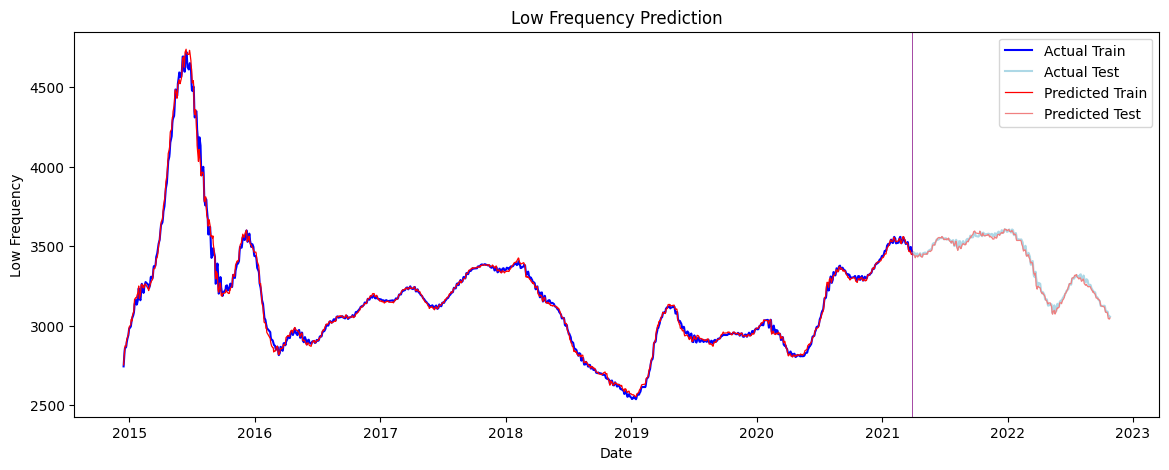

In [55]:
train_pred_low = lf_model.predict(x_train_low)[:,0]
test_pred_low = lf_model.predict(x_test_low)[:,0]

print_metrics(y_test_low[:,0], test_pred_low, scaler_low)
plot_pred(train_pred_low, test_pred_low, y_train_low[:,0], y_test_low[:,0], scaler_low, 'Low Frequency')

### High-Frequency Model

In [56]:
hf_learning_rate = 0.001
hf_gru_units = 512
hf_epochs = 20
hf_batch_size = 8

In [57]:
hf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_len, num_features_high)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=hf_gru_units, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1),
],
name='High_Frequency_BiGRU')

hf_model.compile(optimizer=tf.keras.optimizers.Adam(hf_learning_rate), loss='mean_squared_error', metrics=['mse'])
hf_model.summary()

Model: "High_Frequency_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 10, 1024)       │     1,591,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 1)          │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,592,321 (6.07 MB)

 Trainable params: 1,592,321 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

#### Training and Testing

In [58]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
history = hf_model.fit(x_train_high, y_train_high, epochs=hf_epochs, batch_size=hf_batch_size, validation_split=0.2)

test_loss = hf_model.evaluate(x_test_high, y_test_high)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3485 - mse: 0.3485 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/

#### Prediction and Visualization

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Root Mean Square Error (RMSE): 6.295750117593083
Mean Absolute Error (MAE): 4.9814415881003695
Mean Absolute Percentage Error (MAPE): 0.5988293706255619


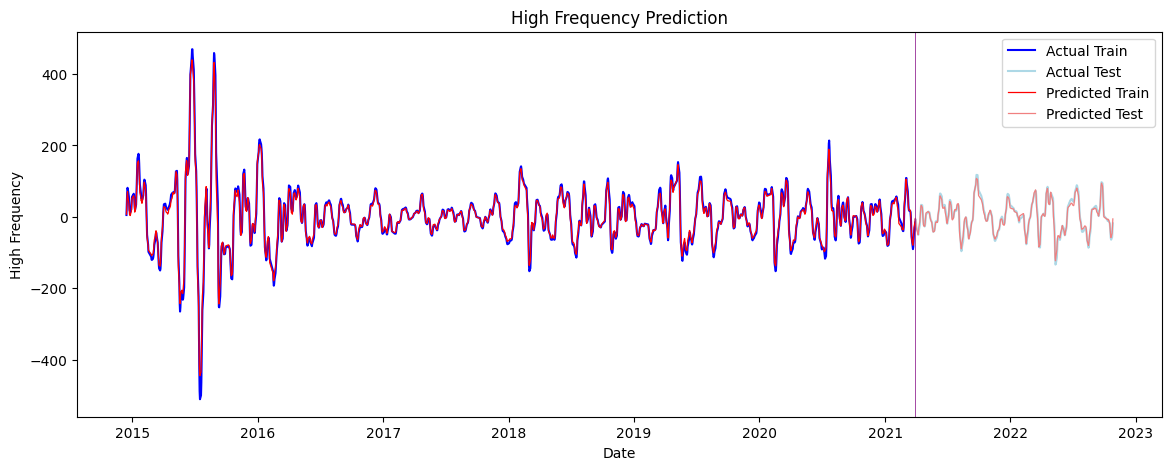

In [67]:
train_pred_high = hf_model.predict(x_train_high)[:,0]
test_pred_high = hf_model.predict(x_test_high)[:,0]

print_metrics(y_test_high[:,0], test_pred_high, scaler_high)
plot_pred(train_pred_high, test_pred_high, y_train_high[:,0], y_test_high[:,0], scaler_high, 'High Frequency')

### Integration Model

In [60]:
x_train = np.concatenate([train_pred_high, train_pred_low], axis=1)
x_test = np.concatenate([test_pred_high, test_pred_low], axis=1)

y = stock_data['close'].loc[integration_index]
integration_scaler = StandardScaler()
y = integration_scaler.fit_transform(y.values.reshape(-1, 1))

y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

x_train = generate_sequences(x_train, seq_len)
x_test = generate_sequences(x_test, seq_len)
y_train = generate_sequences(y_train, seq_len)
y_test = generate_sequences(y_test, seq_len)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test  shape: {x_test.shape}")
print(f"y_test  shape: {y_test.shape}")

x_train shape: (1519, 10, 2)
y_train shape: (1519, 10, 1)
x_test  shape: (373, 10, 2)
y_test  shape: (373, 10, 1)


In [61]:
learning_rate = 0.0003
gru_units = 512
epochs = 20
batch_size = 16

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_len, 2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=gru_units, return_sequences=False)),
    tf.keras.layers.Dense(1),
],
name='Integration_BiGRU')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error', metrics=['mse', 'root_mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()

Model: "Integration_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1024)           │     1,585,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,586,177 (6.05 MB)

 Trainable params: 1,586,177 (6.05 MB)

 Non-trainable params: 0 (0.00 B)

#### Training and Testing

In [63]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit(x_train, y_train, epochs=hf_epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])

test_loss = model.evaluate(x_test, y_test)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.3196 - mean_absolute_error: 0.3414 - mean_absolute_percentage_error: 108.5809 - mse: 0.3196 - root_mean_squared_error: 0.5446 - val_loss: 0.0513 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 181.4872 - val_mse: 0.0513 - val_root_mean_squared_error: 0.2264
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0839 - mean_absolute_error: 0.1878 - mean_absolute_percentage_error: 88.7082 - mse: 0.0839 - root_mean_squared_error: 0.2892 - val_loss: 0.0506 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 183.6508 - val_mse: 0.0506 - val_root_mean_squared_error: 0.2249
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0836 - mean_absolute_error: 0.1846 - mean_absolute_percentage_error: 85.4015 - mse: 0.0836 - root_mean_squared_error: 0.2890 - val_loss: 0.0438 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 170.3124 - val_mse: 0.0438 - val_root_

#### Prediction and Visualization

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Root Mean Square Error (RMSE): 44.827677385549784
Mean Absolute Error (MAE): 35.97019389870979
Mean Absolute Percentage Error (MAPE): 0.010669380711445646


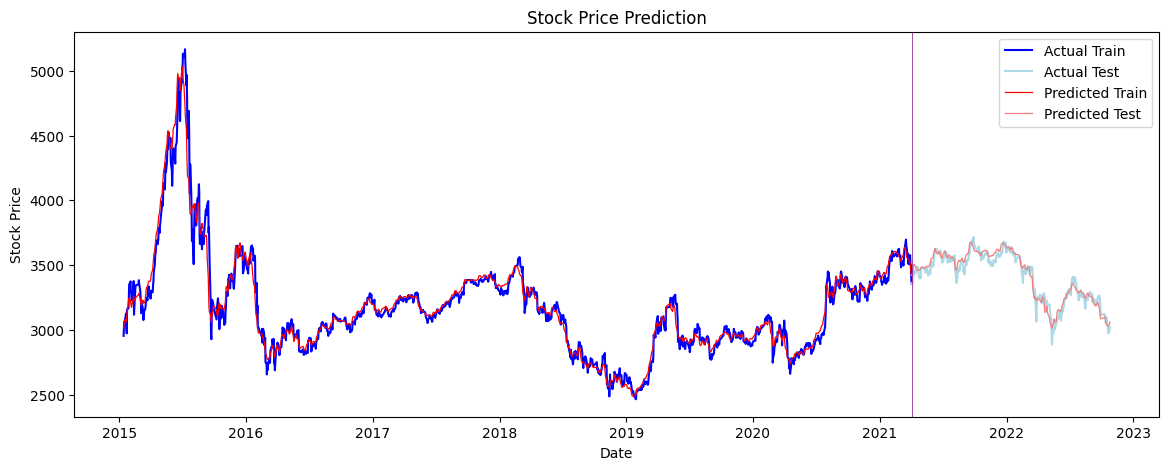

In [64]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

print_metrics(y_test[:,0], test_pred, integration_scaler)
plot_pred(train_pred, test_pred, y_train[:,0], y_test[:,0], integration_scaler, "Stock Price")

### Alternate Prediction Strategy

Root Mean Square Error (RMSE): 20.818994869177466
Mean Absolute Error (MAE): 16.296365119177278
Mean Absolute Percentage Error (MAPE): 0.004832584626411848


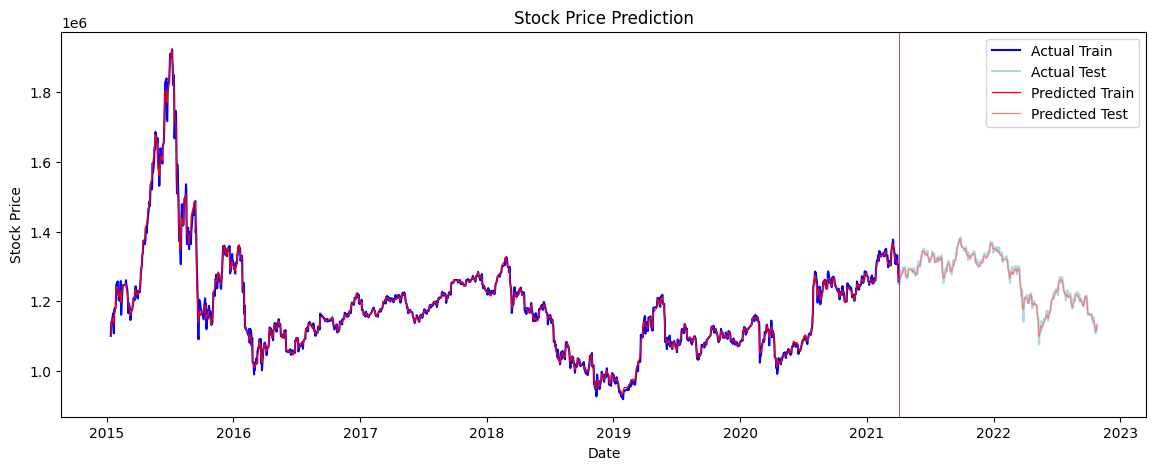

In [65]:
# for the final predictions, sum high + low freq, but transform them back into original scale first
alt_train_pred = np.sum([scaler_low.inverse_transform(train_pred_low), scaler_high.inverse_transform(train_pred_high)], axis=0)[-len(y_train):]
alt_test_pred = np.sum([scaler_low.inverse_transform(test_pred_low), scaler_high.inverse_transform(test_pred_high)], axis=0)[-len(y_test):]

scaled_y_test = integration_scaler.inverse_transform(y_test[:,0])
scaled_y_train = integration_scaler.inverse_transform(y_train[:,0])

print_metrics(y_test[:,0], integration_scaler.transform(alt_test_pred), integration_scaler)
plot_pred(alt_train_pred, alt_test_pred, scaled_y_train, scaled_y_test, integration_scaler, "Stock Price")